# Model to predict **Return** when a customer repurchases a product

### Problem Statement
#### Observation:
It has been observed that some customers are re-purchasing a merchandize (which they have purchased some times back with a higher price) with an "intent to return the repurchased merchandize" to get a "price adjustment" against the "merchandize purchased earlier". 

This behavior is causing Macy’s to loose money by incurring return shipping cost, warehouse cost, restocking cost, etc. This adds up to a significant amount at the end of the year.

** We are going to build a model on historical data (containing transactions where repurchase is observed) to predict and return behavior based on Customer profile , Product Attributes and RFM score.** 


In [2]:
#### Libraries

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from scipy.stats import mode
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 14,}

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#### change path here to point to Raw data

import os
os.chdir("C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\00_Raw_Data")

### Functions:

In [3]:
def quality_report(df):
    """
        Purpose : to create a report of column wise missing value and unique value counts and datatypes 
        Input : Dataframe
        Output : Dataframe with columns names, 
        types, no of observations, no of missing rows, No of unique values,
        % of data avaliable , % of data missing and 
        'Average','SD','MIN','25%','50%','75%','MAX'
        Usage : quality_report(df)

    """
    quality_df = pd.DataFrame()
    quality_df['Col_Name']=df.columns.sort_values()
    sorted_cols = df.columns.sort_values()
    quality_df['Col_Type'] = df[sorted_cols].dtypes.values
    quality_df['No_Of_Observations']=df[sorted_cols].apply(lambda x:len(x)).values
    quality_df['No_Of_Missing_Rows'] = df[sorted_cols].apply(lambda x:np.sum(pd.isnull(x))).values
    quality_df['No_Of_Uniques'] = df[sorted_cols].apply(lambda x:len(x.unique())).values
    quality_df['Data_Avaliable'] = quality_df['No_Of_Observations']-quality_df['No_Of_Missing_Rows']
    quality_df['AvailablePercentage']=np.round(quality_df['Data_Avaliable']/quality_df['No_Of_Observations'],2)
    quality_df['Miss_Pct']=np.round(1-quality_df['AvailablePercentage'],2)
    summary = df.describe().T.reset_index()
    summary.columns=['Col_Name','count','Average','SD','MIN','25%','50%','75%','MAX']
    summary.drop(['count'],axis=1,inplace=True)
    quality_df=pd.merge(quality_df,summary,left_on='Col_Name',right_on='Col_Name',how='outer')
    #quality_df.apply(lambda x:fillna(0, inplace=True))
    quality_df = quality_df.fillna(0)
    return quality_df


def data_arrange(temp_data):
    """
    Usage : take in the transaction sales data and arrange it it time and then group them by CID and UPC
    Input : sales data 
    Output : sales data where previous purchase by same cid and UPC is merged as OLD feilds 
    
    """
    temp_data['r_dt'] = pd.to_datetime(temp_data['r_dt'])
    temp_data['dt'] = pd.to_datetime(temp_data['dt'])
    temp_data = temp_data.sort_values(by="dt").reset_index(None)
    x = pd.DataFrame(temp_data.iloc[0]).T
    y = pd.DataFrame(temp_data.iloc[1]).T

    z = x.merge(y,on=['cid','upc'])
    z.drop(['index_x','index_y',u'web_prod_id_x', u'PROD_DESC_x',u'PROD_TYP_DESC_x', u'BRND_NM_x', u'VND_NM_x', u'GMM_DESC_x',u'PARENT_MDSE_DIVN_DESC_x', u'BUYER_DESC_x', u'MDSE_DEPT_DESC_x',u'LBL_NM_x'],1,inplace=True)
    z.columns = ['cid','upc','oid_old','buy_dt_old','r_dt_old','prc_old','qty_old','amt_old','r_qty_old', 'r_amt_old',
            'oid_new','buy_dt_new','r_dt_new','prc_new','qty_new','amt_new','r_qty_new', u'r_amt_new','web_prod_id', 
             u'PROD_DESC', u'PROD_TYP_DESC',u'BRND_NM', u'VND_NM', u'GMM_DESC', u'PARENT_MDSE_DIVN_DESC',
            u'BUYER_DESC', u'MDSE_DEPT_DESC', u'LBL_NM']
    
    z['prc_chg_dollar'] = z['prc_new'] - z['prc_old']
    z['prc_chg_pct'] = z['prc_chg_dollar']/z['prc_new']
    
    z['time_to_new_purchase'] = (z['buy_dt_new'] - z['buy_dt_old']).dt.days 
    z['prc_chg_per_day'] = z['prc_chg_dollar']/(z['time_to_new_purchase']+1)
    
    z['return_duration_from_recent_buy'] = np.nan
    
    z['return_status'] = "N"
    z['returned_old_flag'] = "N"
    z['return_status_repurchase'] = 0
    
    if np.isnan(z.r_qty_new.values[0]) & np.isnan(z.r_qty_old.values[0]):
        z['return_status'] = "Both Kept"
        z['return_status_repurchase'] = 0
    elif ((not np.isnan(z.r_qty_new.values[0])) & (not np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Both Returned"
        z['return_status_repurchase'] = 1
    elif ((np.isnan(z.r_qty_new.values[0])) & (not np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Returned Old"
        if (z.r_dt_old.values[0] != "") & (z.buy_dt_new.values[0] > z.r_dt_old.values[0]):
            z['return_duration_from_recent_buy'] = (z['r_dt_old'] - z['buy_dt_new']).dt.days
            z['returned_old_flag'] = "Y"
            z['return_status_repurchase'] = 0
        else:
            z['return_status_repurchase'] = 1
            z['returned_old_flag'] = "N"
    elif ((not np.isnan(z.r_qty_new.values[0])) & (np.isnan(z.r_qty_old.values[0]))):
        z['return_status'] = "Returned New"
        z['return_status_repurchase'] = 1
    
    return z


######### ---------------- Select only specific columns ----------- ############# 

def colums_to_select(main_data,filePath):
    """
    Purpose : Takes in a dataset and a CSV where column to select are defined and 
    selects only those columns.
    Inputs: Dataframe , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with desired columns selected
    Usage : type_conversion(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    select_vars = quality_report.loc[quality_report.Col_Keep =='Y','Col_Name']
    main_data = main_data[select_vars]
    
    return(main_data)


def type_conversion(main_data,filePath):
   
    """
    Purpose : Takes in a dataset and a CSV where column types are defined and 
    converts each column in the dataset to the format specified in the CSV
    **working**: shoul Not  contains missing values in float or int type columns.
    Inputs: Dataframe to convert , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with desired datatype conversions
    Usage : type_conversion(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    quality_report=quality_report.loc[(quality_report.Col_Keep =='Y'),]
    #print(quality_report.shape)
    int_vars = quality_report.loc[quality_report.Col_Type_Def=='int64','Col_Name']
    float_vars = quality_report.loc[quality_report.Col_Type_Def=='float64','Col_Name']
    obj_vars = quality_report.loc[quality_report.Col_Type_Def=='object','Col_Name']
    date_vars = quality_report.loc[quality_report.Col_Type_Def=='datetime','Col_Name']
    
    for cols in int_vars:
        main_data[cols]=main_data[cols].astype('int64')
    for cols in float_vars:
        main_data[cols]=main_data[cols].astype('float64')
    for cols in obj_vars:
        main_data[cols]=main_data[cols].astype('object')
    for cols in date_vars:
        main_data[cols] = pd.to_datetime(main_data[cols])
        
    return(main_data)

######### ---------------- Creating dummies of categorical variables ----------- ############# 

def create_dummies_file(main_data,filePath):
    

    """
    Purpose : Takes in a dataset and a CSV where column def are present 
    identifies the cat variables and creates dummies for those variables
    Inputs: Dataframe , File name with path in python format if file is not in CWD. 
    Outputs: Input DataFrame with dummies created for all categorical variables
    Usage : create_dummies_file(df,"path\\filename.csv")
    
    """
    quality_report = pd.read_csv(filePath)
    quality_report = quality_report.loc[(quality_report.Col_Keep =='Y'),]
    dummy_vars = quality_report.loc[quality_report.Col_Type_Def =='object','Col_Name']
    main_data = pd.get_dummies(main_data,columns= dummy_vars)
    return(main_data)



def bivar_plot(data,attribute,fig_widht=12,fig_height=6,width=0.5,Stacked=True,legend=True):
    
    ##-----------------plot for to find return rate for each level of categorical attribute-------##
    
    fig, axs = plt.subplots(1,2,figsize=(fig_widht,fig_height),squeeze=0)
    sorted_names = data[attribute].value_counts().index
    temp_df = pd.crosstab(data[attribute],data.return_status_repurchase,normalize='index')
    temp_df.reset_index(inplace=True)
    temp_df.columns = ['Levels','No_prop','Yes_prop']
    temp_df2 = pd.DataFrame(sorted_names)
    temp_df2.columns = ['Levels']
    df_Final = pd.merge(temp_df2,temp_df,left_on='Levels',right_on='Levels')
    df_Final.plot(kind='bar',stacked=Stacked,legend=0,color=['#FF6D31','#29A2C6'],ax=axs[0,0],width=width)
    axs[0,0].set_xticklabels(df_Final.Levels, rotation='90',size=15)
    axs[0,0].set_title(attribute+ ' vs Target',size=20,fontweight='bold')
    if(legend==True):
        axs[0,0].legend(bbox_to_anchor=(1.1, 1.05),loc='right')
    
    ##-----------------plot for to notic count of each level in categorical attribute-------##
    
    data[attribute].value_counts().plot(kind='bar',ax=axs[0][1],width=width,color='#6bb69c')
    plt.title('Frequency of Categories',size=20,fontname="Arial",fontweight="bold")
    plt.setp(axs[0, 1].get_xticklabels(),rotation='90',size=15)
#     axs[0,1].set_xlabel(attribute,size=15,fontname="Calibri")
    axs[0,1].set_ylabel('Frequency',size=15,fontname="Calibri")
    if(legend==True):
        axs[0,1].legend(bbox_to_anchor=(1.1, 1.05),loc='right')
    plt.tight_layout()
    plt.savefig(attribute+'.png')
    
def v_confusion_matrix(confusion_matrix_train,confusion_matrix_test,title='CONFUSION MATRIX'):
    df_cm_train = confusion_matrix_train
    df_cm_test = confusion_matrix_test
    fig = plt.figure(figsize=(8,8))
    fig, axs = plt.subplots(1,2,figsize=(8,2),squeeze=0)
    
    sns.heatmap(df_cm_train,annot=True,fmt='g',ax=axs[0,0], annot_kws={"size": 20})
    sns.heatmap(df_cm_test,annot=True,fmt='g',ax=axs[0,1], annot_kws={"size": 20})
    plt.subplots_adjust(left=-0.3, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.suptitle(title,x=0.25,y=1.2,fontweight='bold')
    axs[0,0].set_title("On Trained Data",y=-0.5)
    axs[0,1].set_title("On Test Data",y=-0.5)
#     print(accuracy_score(actual,predicted))
    
    for i in [0,1]:
        #axs[0,i].set_title("Title for second plot")
        axs[0,i].set_xlabel('Predicted', fontsize = 15)
        axs[0,i].set_ylabel('Actual', fontsize = 15)
        axs[0,i].xaxis.set_tick_params(labelsize=15,labeltop='on',labelbottom='off')
        axs[0,i].yaxis.set_tick_params(labelsize=15)
    #plt.savefig(attribute+'.png')
    

def hist_var(data,attribute,bin_size=10):
    
    plt.figure(figsize=(4,4))
    _, edges = np.histogram(data[attribute], bins=10)
    histdata = []; labels=[]
    for n, group in data.groupby("return_status_repurchase"):
        histdata.append(np.histogram(group[attribute], bins=edges)[0])
        labels.append(n)
    
    hist = np.array(histdata) 
    histcum = np.cumsum(hist,axis=0)
    
    plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
                label=labels[0], align="edge",color='#FF6D31')
    
    for i in range(1,len(hist)):
        plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
                bottom=histcum[i-1,:],label=labels[i], align="edge",color='#29A2C6')
   # attribute = 'time_to_new_purchase'
    #plt.legend(title="Return_Status")
    plt.title('Distribution of '+ attribute,fontweight='bold',size=13)
    plt.xlabel(attribute,size=15)
    plt.ylabel('Frequency',size=15)
    plt.show()
    
def roc_cutoffs(model,X,y):
    df=pd.DataFrame()
    i=0
    df['cutoff']=np.arange(0.1,1.0,0.1)
    #working: have to return the best cutoff 
    for cutoff in np.arange(0.1,1.0,0.1):
        x = pd.DataFrame(model.predict_proba(X))[1].map(lambda x: 1 if x>cutoff else 0)
        cf=confusion_matrix(y,x)
        TPR = cf[1,1]/(cf[1,1]+cf[1,0])
        FPR = cf[0,1]/(cf[0,0]+cf[0,1])
        df.loc[i,'Accuracy_Score']=accuracy_score(y,x)
        df.loc[i,'TPR']=TPR
        df.loc[i,'FPR']=FPR
        i=i+1
    return df

### Datasets

we have the following datasets 
>* Sales data - transactions
>* Product Attributes
>* Customer Attributes
>* RFM Score and related attributes
>* Customer history of returns


In [4]:
#### Sales data with Product Details Attached 
    #Find the Source SQL from Vaibhav and collate

main_data = pd.read_csv("Macys_Repurchase_Product.csv",encoding='latin-1')
# main_data.head(5)
    
#### Customer Data 

cust_data = pd.read_csv("Customer_data.csv",encoding='latin-1')
# cust_data.head(5)

#### RFM Score Data

RFM_data = pd.read_csv("RFM_score_data.csv")
# RFM_data.head(5)

#### Customer History of returns

cust_ret_data = pd.read_csv("customer_history_returns.csv")

In [5]:
RFM_data.DIST_TO_STR_RESID_NBR

0         8
1         3
2         5
3         3
4         3
5        10
6         1
7         2
8         3
9         3
10      999
11        6
12        7
13        6
14        3
15        4
16        6
17        2
18        2
19        3
20        6
21        7
22        1
23        8
24        5
25        2
26        2
27       11
28        4
29        3
       ... 
7220      4
7221      2
7222      5
7223      4
7224     10
7225      2
7226      2
7227      3
7228      3
7229      2
7230      6
7231      4
7232      1
7233      3
7234      1
7235      7
7236      7
7237      2
7238      3
7239     10
7240      3
7241      5
7242      7
7243     10
7244      4
7245      5
7246      6
7247      5
7248      2
7249      3
Name: DIST_TO_STR_RESID_NBR, Length: 7250, dtype: int64

# We have to do some calculations and transformations on the historical data to get the target variable

### In the intrim we are alro derriving a few attributes that adds more defination to the repurchase behavior
### Once repurchase behavior is detected we shall go ahead and predict if the repurchased product is succeptible to return

* prc_chg_dollar
* prc_chg_pct
* time_to_new_purchase
* prc_chg_per_day
* return_duration_from_recent_buy
* return_status
>* Both Kept
>* Both Returned
>* Returned Old
>* Returned New

In [6]:
# ####### we are taking the sales data to be grouped by CID and UPC 
# ### filtering on this count will only keep the customers who have repurchased a cetain product within this timeframe

# count_data = main_data.groupby(['cid','upc']).size().reset_index(None)
# count_data.columns = ['cid','upc','count']

# ### after the data has been transformed and change variables calculated , 
# ## we are going to be only taking the customer product pairs that exhibited repurchase behaviour


# count_2 = count_data[count_data['count']==2]
# new_data = pd.DataFrame()
# for ix in range(len(count_2)):
#     temp_cid = count_2.iloc[ix].cid
#     temp_upc = count_2.iloc[ix].upc
#     temp_data = main_data[(main_data.cid == temp_cid) & (main_data.upc == temp_upc) ]
#     temp_data = data_arrange(temp_data)
    
#     new_data = new_data.append(temp_data)
    
# #### Print a sample of processed sales_prod data
# print("Example of data after all processing is done on sales data\n")
# new_data['cid'] = new_data['cid'].apply(lambda x: int(x.replace(',', '')))
# new_data.head(2)

### Analysis Starts Here:

### Loading Reshaped Data:

In [7]:
path = 'C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Pavan\\Source_Data_and_Analysis\\Data_Exploration\\'
new_data = pd.read_csv(path+'reshaped_sales_Data.csv',encoding='latin-1')

### Target Distribution:

In [8]:
new_data.groupby("return_status_repurchase").size()

return_status_repurchase
0    4708
1    4215
dtype: int64

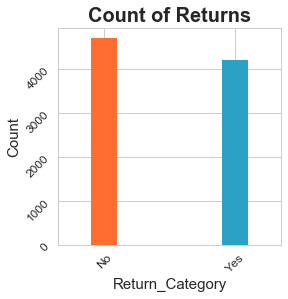

In [9]:
new_data.groupby("return_status_repurchase").size().plot(kind='bar',figsize=(4,4),color=['#FF6D31','#29A2C6'],width=0.2)
plt.title('Return_Count',size=20,fontname="Arial",fontweight="bold")
plt.xticks([0,1],['No','Yes'],rotation='45',size=12)
plt.yticks(rotation='45',size=12)
plt.xlabel('Return_Category',size=15)
plt.ylabel('Count',size=15)
plt.title('Count of Returns',size=20,fontname="Arial",fontweight="bold")

### Return_Status Categoires Proportions:

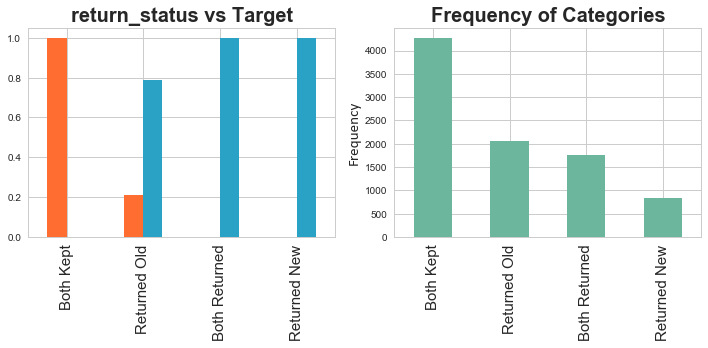

In [10]:
bivar_plot(data=new_data,attribute='return_status',Stacked=False,width=0.5,fig_height=5,fig_widht=10,legend=False)

### Data Preparation of Base Model: Dropping Columns which all rows as nulls:

In [11]:
main_data = new_data.copy(deep=True)
main_data = main_data.dropna(axis=1, how='all')

In [12]:
#### selecting specific columns 
filepath1 = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\main_Data_Dict.csv"

main_data = colums_to_select(main_data,filepath1)
# main_data= main_data.reset_index()
# main_data = main_data.drop(['index'],axis=1)
# main_data.index

############# Some float values are missing############ 

### Dropping rows:72

indexes = list(main_data.loc[(main_data.amt_new==0)|(main_data.amt_old==0)|(main_data.prc_new==0)|(main_data.prc_old==0),].index)
main_data = main_data.drop(main_data.index[[indexes]])
main_data.shape
main_data.apply(lambda x: sum(pd.isnull(x)))

GMM_DESC                    138
PARENT_MDSE_DIVN_DESC       138
amt_new                       0
amt_old                       0
prc_chg_dollar                0
prc_chg_pct                   0
prc_chg_per_day               0
prc_new                       0
prc_old                       0
qty_new                       0
qty_old                       0
return_status_repurchase      0
returned_old_flag             0
time_to_new_purchase          0
dtype: int64

### Datatypes Conversion of Attributes:

In [13]:
main_data = type_conversion(main_data,filepath1)
main_data.dtypes

GMM_DESC                     object
PARENT_MDSE_DIVN_DESC        object
amt_new                     float64
amt_old                     float64
prc_chg_dollar              float64
prc_chg_pct                 float64
prc_chg_per_day             float64
prc_new                     float64
prc_old                     float64
qty_new                       int64
qty_old                       int64
return_status_repurchase      int64
returned_old_flag            object
time_to_new_purchase          int64
dtype: object

In [14]:
main_data.return_status_repurchase.tail()

8918    1
8919    1
8920    0
8921    0
8922    0
Name: return_status_repurchase, dtype: int64

### Working wiht Customers Demographic data and RFM_Scored Data:

In [15]:
cust_data = cust_data.dropna(axis=1, how='all')
RFM_data = RFM_data.dropna(axis=1, how='all')

## Drop Columns that are not required 


>* we have created the Excel files listing the feilds to keep and the feilds to remove
>* We shall keep IDs for now and then remove them later after merge
>* Once Columns are dropped we shall check the shape of the dataset

In [16]:
#### These are the files where the columns to keep and remove are specified

filepath_cust = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\cust_Data_Dict.csv"
filepath_RFM = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\RFM_Data_Dict.csv"
filepath_main = "C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Lavanya\\00_Model_Building\\02_Intermediate_Datasets\\02_Used_by_code\\main2_Data_Dict.csv"

In [17]:
### Apply function to remove columns specified in the above CSVs
new_data = colums_to_select(new_data,filepath_main)
cust_data = colums_to_select(cust_data,filepath_cust)
RFM_data = colums_to_select(RFM_data,filepath_RFM)

### Date Fixing:

In [18]:
### A few changes to deal with OutOfBound ERROR !! 

RFM_data.loc[RFM_data.EXT_ONLN_FRST_PURCH_DT=="0001-01-01", 'EXT_ONLN_FRST_PURCH_DT'] = "01-01-01"
RFM_data.loc[RFM_data.FRST_PURCH_DT=="1-01-01", 'FRST_PURCH_DT'] = "01-01-01"
RFM_data.loc[RFM_data.FRST_PURCH_DT=="0001-01-01", 'FRST_PURCH_DT'] = "01-01-01"
RFM_data.loc[RFM_data.EXT_ONLN_FRST_PURCH_DT=="1-01-01", 'EXT_ONLN_FRST_PURCH_DT'] = "01-01-01"

### Datatype Conversion:

In [19]:
### The filepath that contains the columns to keep also contains the datatype of each column specified by the user
### Applying the Function to convert the datatype

new_data = type_conversion(new_data,filepath_main)
cust_data = type_conversion(cust_data,filepath_cust)
RFM_data = type_conversion(RFM_data,filepath_RFM)

### Derived Variables 

In [20]:
#########------------CUSTOMER_DEMOGRAPHIC_DATA-------------------------###############

cust_data['DOB_DT'] = pd.to_datetime(cust_data['DOB_DT'])
cust_data['Age_Calculated'] = cust_data['DOB_DT'].apply(lambda born: (dt.date.today().year - born.year - ((dt.date.today().month, dt.date.today().day) < (born.month, born.day))))


###########-------------RFM_DATA--------------------##############

RFM_data['lifetime'] = (RFM_data['LST_PURCH_DT'] - RFM_data['FRST_PURCH_DT']).dt.days

In [21]:
RFM_data['online_lifetime'] = (RFM_data['ONLN_LST_PURCH_DT'] - RFM_data['ONLN_FRST_PURCH_DT']).dt.days
RFM_data['str_lifetime'] = (RFM_data['STR_LST_PURCH_DT'] - RFM_data['STR_FRST_PURCH_DT']).dt.days
RFM_data['str_to_online_lag'] = (RFM_data['str_lifetime'] - RFM_data['online_lifetime'])

###########-------------CUST_RET-HISTORY--------------------##############

cust_ret_data['Diff_Count'] = cust_ret_data.TOT_BUY_COUNT - cust_ret_data.TOT_RET_COUNT
cust_ret_data['Diff_Qty']= cust_ret_data.TOT_BUY_QTY - cust_ret_data.TOT_RET_QTY
cust_ret_data['Diff_Amt'] =  cust_ret_data.TOT_BUY_AMT - cust_ret_data.TOT_RET_AMT
cust_ret_data['per_Diff_Count'] = cust_ret_data.TOT_RET_COUNT/cust_ret_data.TOT_BUY_COUNT
cust_ret_data['per_Diff_Qty']= cust_ret_data.TOT_RET_QTY/cust_ret_data.TOT_BUY_QTY
cust_ret_data['per_Diff_Amt'] =  cust_ret_data.TOT_RET_AMT/cust_ret_data.TOT_BUY_AMT

##### Dropping Some Unsignificant attributes:

In [22]:
RFM_data = RFM_data.drop(['EXT_ONLN_FRST_PURCH_DT', 'FRST_PURCH_DT', 'FRST_REG_DT', 'INDIV_LST_PURCH_DT', 'LST_PURCH_DT', 'ONLN_FRST_PURCH_DT', 'ONLN_LST_PURCH_DT', 'STR_FRST_PURCH_DT', 'STR_LST_PURCH_DT'], axis=1)

cust_ret_data = cust_ret_data.drop(['TOT_RET_COUNT', 'TOT_RET_QTY', 'TOT_RET_AMT', 'Diff_Count', 'Diff_Qty','Diff_Amt'], axis=1)

## Merge All sets 

In [23]:
tot_data = pd.merge(new_data, cust_ret_data,left_on='cid', right_on='INDIV_ID', how='left')
tot_data = pd.merge(tot_data, cust_data,left_on='cid', right_on='cid', how='left')
tot_data = pd.merge(tot_data, RFM_data,left_on='cid', right_on='INDIV_ID', how='left')

## Drop the IDs used to perform Merge

In [24]:
tot_data = tot_data.drop(['cid','INDIV_ID_x','DOB_DT','INDIV_ID_y'],axis = 1 )

## Check the Final Dataset

In [25]:
tot_data.head(2)

,GMM_DESC,PARENT_MDSE_DIVN_DESC,amt_new,amt_old,prc_chg_dollar,prc_chg_pct,prc_chg_per_day,prc_new,prc_old,qty_new,...,PRIZM_DESC,PROP_ACCT_CNT,PRSPCT_ACCT_CNT,RFM_SEG_IND,R_SCR_NBR,TOT_ACCT_CNT,lifetime,online_lifetime,str_lifetime,str_to_online_lag
0,READY TO WEAR,SPECIAL SIZES,7.74,11.99,-4.25,-0.549096,-0.472222,7.74,11.99,1,...,99 - Unassigned (null),2.0,35.0,1,5,6.0,3750.0,2587.0,3031.0,444.0
1,MENS & KIDS,TOTAL CHILDRENS,23.99,45.00,-21.01,-0.875782,-0.656563,23.99,45.00,1,...,99 - Unassigned (null),2.0,35.0,1,5,6.0,3750.0,2587.0,3031.0,444.0


In [26]:
tot_data = tot_data.drop(['EMP_CD'],axis = 1 )

## Remove Missing Values or impute them accordingly

In [27]:
tot_data = tot_data.dropna(axis=0)
tot_data.shape

(6495, 56)

In [28]:
# tot_data.isnull().sum()

removeinf = tot_data.prc_chg_pct.min()

tot_data.prc_chg_pct = tot_data[tot_data.prc_chg_pct != removeinf]
tot_data = tot_data.drop(['prc_chg_pct'],axis = 1)

## Data exploration:

return_status_repurchase         0         1
GMM_DESC                                    
BEAUTY                    0.851064  0.148936
CENTER CORE               0.457017  0.542983
COST/WORKROOM/LEASE       0.527778  0.472222
HOME                      0.651741  0.348259
MENS & KIDS               0.456122  0.543878
MISCELLANEOUS             0.692308  0.307692
READY TO WEAR             0.312716  0.687284


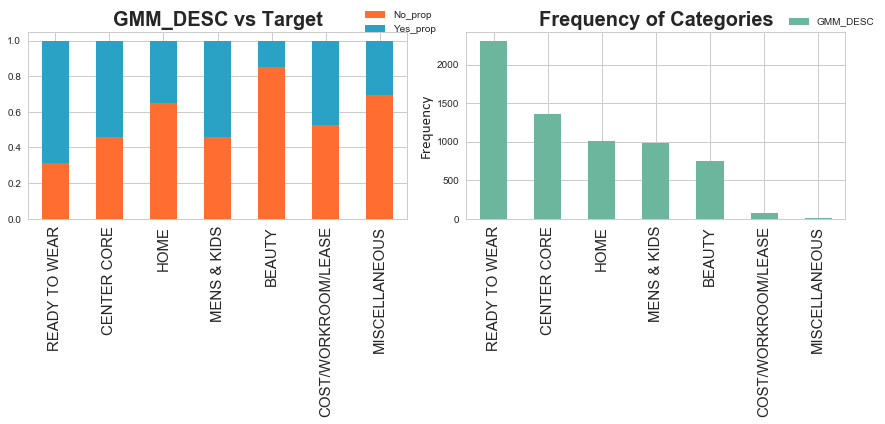

In [29]:
print(pd.crosstab(tot_data['GMM_DESC'],tot_data.return_status_repurchase,normalize='index'))
bivar_plot(tot_data,'GMM_DESC')
###Comment: Readytowear  category has more returns compared to all other.

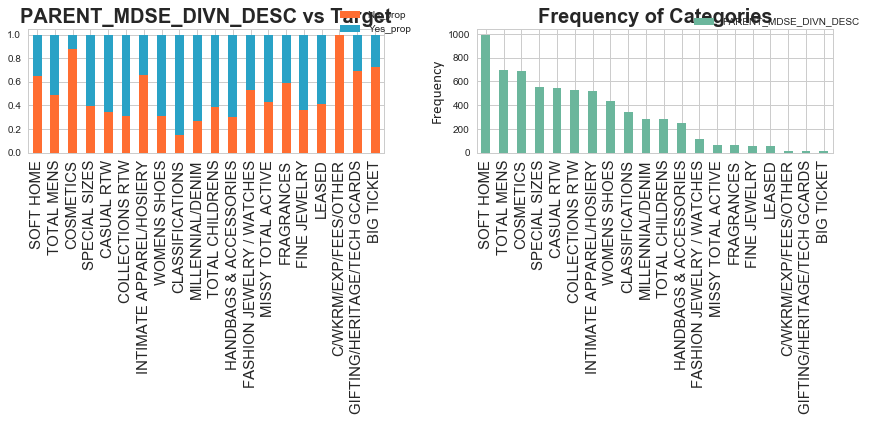

In [30]:
#print((pd.crosstab(tot_data['PARENT_MDSE_DIVN_DESC'],tot_data.return_status_repurchase,normalize='index')))

bivar_plot(tot_data,'PARENT_MDSE_DIVN_DESC')
##CLASSIFICATIONS  Category has more returns (about 85%)  and next has MILLENNIAL/DENIM (73%) has high returns.

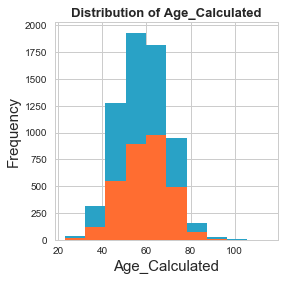

In [31]:
hist_var(data=tot_data,attribute='Age_Calculated',bin_size=10)
##Comment: People Age b/w 22 to 49 are high returns compared to another ages

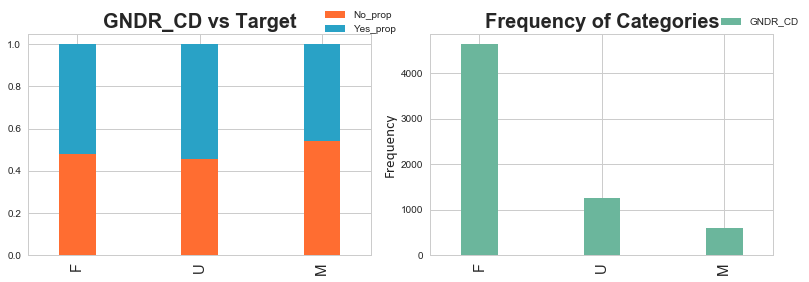

In [32]:
bivar_plot(tot_data,"GNDR_CD",fig_widht=11,fig_height=4,width=0.3)

## Comment: Slightly males are retuning high compared to female and others(U) 

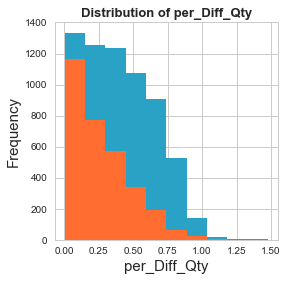

In [33]:
hist_var(data=tot_data,attribute='per_Diff_Qty',bin_size=15)

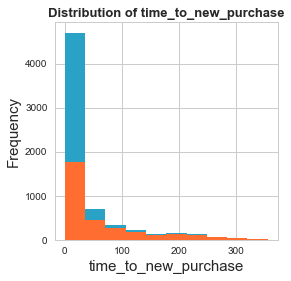

In [34]:
hist_var(data=tot_data,attribute='time_to_new_purchase',bin_size=15)

# Comment: If a customer  buys a product after within 18 days then he is the 
# most probable to return that product


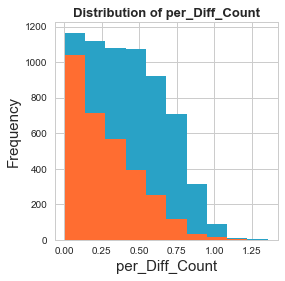

In [35]:
hist_var(data=tot_data,attribute='per_Diff_Count',bin_size=15)
#Coment: If person has total_return_count 75%  of his tot_buy_count then 
# he is more probable to return


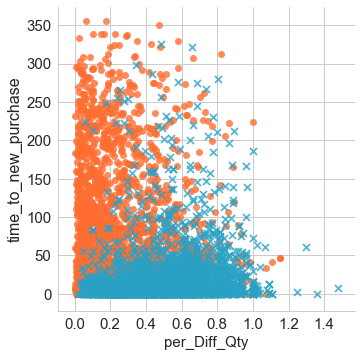

In [36]:
# sns.set_style(style='white')
sns.lmplot( x='per_Diff_Qty', y='time_to_new_purchase', data=tot_data, fit_reg=False, hue='return_status_repurchase',markers=["o", "x"],palette=['#FF6D31','#29A2C6'],legend=0)
plt.xlabel('per_Diff_Qty',size=15)
plt.ylabel('time_to_new_purchase',size=16)
plt.xticks(size=15),
plt.yticks(size=15)
#plt.legend(loc='best',labels=['No_returns','Returns'])
plt.show()

#comment: if person ret_qty 20% more than buy_qty and he is new purchase the item within 3 months then 
#most probable to return the products


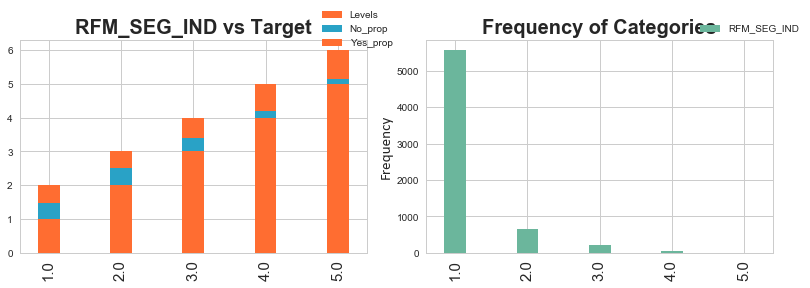

In [37]:
tot_data = tot_data.loc[tot_data.RFM_SEG_IND!=0.0,]
bivar_plot(tot_data,'RFM_SEG_IND',fig_widht=11,fig_height=4,width=0.3)

## Check Corr plot and keep one of the two correlated variables 

Correlation plot of Main Data



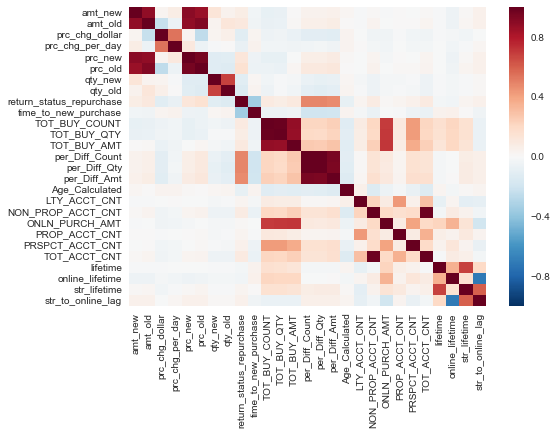

In [38]:
## Check the independence between the independent variables
sns.heatmap(tot_data.corr())
# ,annot=True,linewidths=.5
print("Correlation plot of Main Data\n")
plt.show()

## Create Dummy variables for Categorical variables 

In [39]:
# dummy_vars = ['AFLT_IND', 'CURR_DH_MY_LIFE_DESC', 'CURR_DH_SHOP_HABIT_DESC', 'CUR_OIS_DESC', 'DLVR_SEQ_FILE_DLVR_IND_CD_DESC', 'DLVR_SEQ_FILE_DLVR_TYP_CD_DESC', 'EMP_IND', 'FED_EMP_IND', 'F_SCR_NBR', 'GMM_DESC', 'GNDR_CD', 'KEPT_ACCT_TYP_CD', 'KEPT_SOURCE_CD_DESC', 'MAX_STAR_RWD_SPND_LVL_DESC', 'MAX_VIP_CD_DESC', 'MBL_PHN_IND', 'M_SCR_NBR', 'PARENT_MDSE_DIVN_DESC', 'PRIZM_DESC', 'RFM_SEG_IND', 'R_SCR_NBR', 'SEASNL_IND', 'SEC_NBR_NOT_FND_IND', 'SMS_IND', 'SUPPR_DMA_MAIL_IND', 'VACNT_IND', 'VLD_EMAIL_ADDR_IND' ,'returned_old_flag']
tot_data = tot_data[['prc_old','qty_old','amt_old','GMM_DESC','PARENT_MDSE_DIVN_DESC','prc_new','qty_new','amt_new','prc_chg_dollar','time_to_new_purchase','prc_chg_per_day','returned_old_flag','return_status_repurchase','TOT_BUY_COUNT','per_Diff_Qty','per_Diff_Amt','RFM_SEG_IND','ONLN_PURCH_AMT','R_SCR_NBR','F_SCR_NBR','M_SCR_NBR','lifetime','GNDR_CD','Age_Calculated']]
dummy_vars = tot_data.select_dtypes(include=['object']).columns
tot_data_final = pd.get_dummies(tot_data,columns= dummy_vars)

#### Conveting into days:

In [40]:
# tot_data['lifetime'] = (tot_data['lifetime'] / np.timedelta64(1, 'D')).astype(int)
# tot_data['online_lifetime'] = (tot_data['online_lifetime'] / np.timedelta64(1, 'D')).astype(int)
# tot_data['str_lifetime'] = (tot_data['str_lifetime'] / np.timedelta64(1, 'D')).astype(int)
# tot_data['str_to_online_lag'] = (tot_data['str_to_online_lag'] / np.timedelta64(1, 'D')).astype(int)

In [41]:
#list(tot_data)

## Perform the test train split 

In [42]:
X = tot_data_final.drop(['return_status_repurchase'],axis=1)
y = tot_data_final['return_status_repurchase']


#20% test data and 80% train set.
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state= 0) 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(5195, 67)
(5195,)
(1299, 67)
(1299,)


### Fit the Logistic Model into data 

In [43]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Performance Metrics:

#### Confusion Matrix 

In [44]:
print('Accuracy of Logistic Regression on Train data:',accuracy_score(y_train,model_logistic.predict(X_train)))
print('Accuracy of Logistic Regression on Test data:',accuracy_score(y_test,model_logistic.predict(X_test)))

Accuracy of Logistic Regression on Train data: 0.810972088547
Accuracy of Logistic Regression on Test data: 0.795227097768


In [45]:
X_train.head()

,prc_old,qty_old,amt_old,prc_new,qty_new,amt_new,prc_chg_dollar,time_to_new_purchase,prc_chg_per_day,TOT_BUY_COUNT,...,F_SCR_NBR_4.0,F_SCR_NBR_5.0,M_SCR_NBR_1.0,M_SCR_NBR_2.0,M_SCR_NBR_3.0,M_SCR_NBR_4.0,M_SCR_NBR_5.0,GNDR_CD_F,GNDR_CD_M,GNDR_CD_U
1451,13.99,1,13.99,9.99,1,9.99,-4.00,17,-0.222222,53.0,...,0,1,0,0,0,0,1,1,0,0
1162,8.00,2,16.00,6.66,2,13.32,-1.34,113,-0.011754,83.0,...,0,1,0,0,0,0,1,0,0,1
1324,14.99,1,14.99,15.99,1,15.99,1.00,5,0.166667,540.0,...,0,1,0,0,0,0,1,1,0,0
2248,37.39,1,37.39,36.79,1,36.79,-0.60,123,-0.004839,237.0,...,0,1,0,0,0,0,1,1,0,0
3605,70.73,1,70.73,48.09,1,48.09,-22.64,0,-22.640000,389.0,...,0,1,0,0,0,0,1,1,0,0


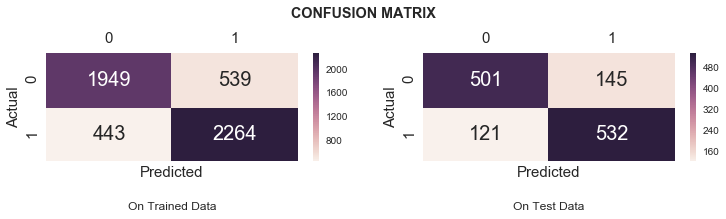

In [46]:
v_confusion_matrix(confusion_matrix(y_train,model_logistic.predict(X_train)),confusion_matrix(y_test,model_logistic.predict(X_test)))

## Fit the GBM Model to Data:

In [51]:
# os.chdir('C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Pavan\\Source_Data_and_Analysis\\Final Results\\')
# os.listdir()
import pickle
with open('new_gbm_24vars.pkl', 'rb') as f:
    clf_new = pickle.load(f)

In [52]:
clf_new.

array([[ DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort='auto',
           random_state=<mtrand.RandomState object at 0x0000022DC0E9BF78>,
           splitter='best')],
       [ DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort='auto',
           random_state=<mtrand.RandomState object at 0x0000022DC0E9BF78>,
           splitter='best')],
       [ DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           preso

In [54]:
# model_gbm = GradientBoostingClassifier(random_state=42)
# model_gbm.fit(X_train,y_train)
print('Accuracy of GBM on TRAIN_DATA:',accuracy_score(y_train,clf_new.predict(X_train)))
print('Accuracy of GBM on TEST_DATA:',accuracy_score(y_test,clf_new.predict(X_test)))

Accuracy of GBM on TRAIN_DATA: 0.850433108758
Accuracy of GBM on TEST_DATA: 0.828329484219


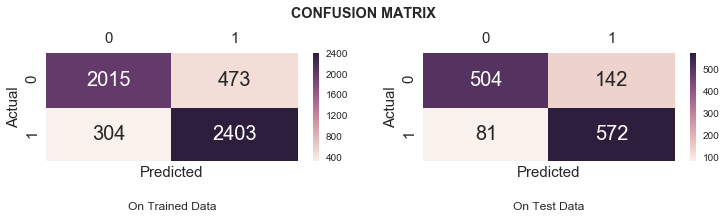

In [78]:
v_confusion_matrix(confusion_matrix(y_train,model_gbm.predict(X_train)),confusion_matrix(y_test,model_gbm.predict(X_test)))

### Featrues Impacting the Target:

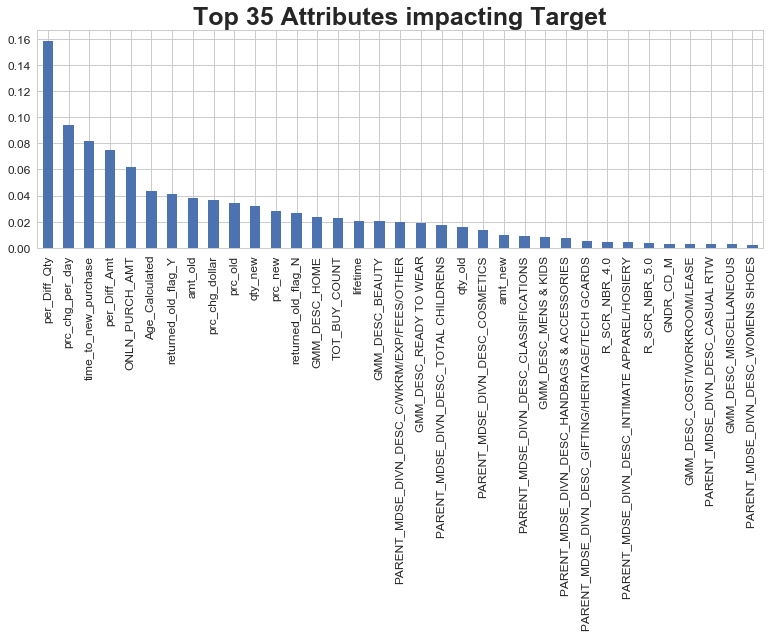

In [79]:
plt.figure(figsize=(13,4))
feat_imp = pd.Series(clf_new.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp[:35].plot(kind='bar', title='Top 15 Features')
plt.title('Top 35 Attributes impacting Target',fontweight='bold',fontsize=25)
plt.yticks( fontsize=12)
plt.xticks( fontsize=12)
plt.show()

#### AUC-ROC :

   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.698999  0.992343  0.597523
1     0.2        0.762895  0.967841  0.444272
2     0.3        0.796767  0.935681  0.343653
3     0.4        0.819092  0.912711  0.275542
4     0.5        0.828329  0.875957  0.219814
5     0.6        0.826790  0.807044  0.153251
6     0.7        0.806774  0.732006  0.117647
7     0.8        0.762125  0.592649  0.066563
8     0.9        0.647421  0.323124  0.024768


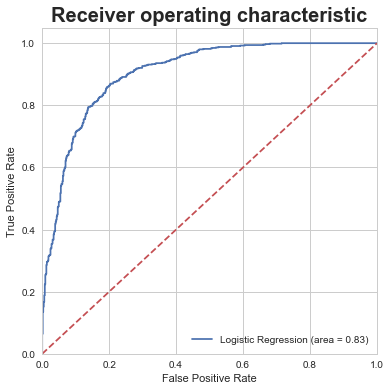

In [80]:
print(roc_cutoffs(model=model_gbm,X=X_test,y=y_test))

plt.figure(figsize=(6,6))
logit_roc_auc = roc_auc_score(y_test,model_gbm.predict(X_test))
#print('Area under ROC curve is:',logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test,model_gbm.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic',size=20,fontname="Arial",fontweight="bold")
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [83]:
tot_data.columns

24

In [82]:
tot_data_final.columns

Index(['prc_old', 'qty_old', 'amt_old', 'prc_new', 'qty_new', 'amt_new',
       'prc_chg_dollar', 'time_to_new_purchase', 'prc_chg_per_day',
       'return_status_repurchase', 'TOT_BUY_COUNT', 'per_Diff_Qty',
       'per_Diff_Amt', 'ONLN_PURCH_AMT', 'lifetime', 'Age_Calculated',
       'GMM_DESC_BEAUTY', 'GMM_DESC_CENTER CORE',
       'GMM_DESC_COST/WORKROOM/LEASE', 'GMM_DESC_HOME', 'GMM_DESC_MENS & KIDS',
       'GMM_DESC_MISCELLANEOUS', 'GMM_DESC_READY TO WEAR',
       'PARENT_MDSE_DIVN_DESC_BIG TICKET',
       'PARENT_MDSE_DIVN_DESC_C/WKRM/EXP/FEES/OTHER',
       'PARENT_MDSE_DIVN_DESC_CASUAL RTW',
       'PARENT_MDSE_DIVN_DESC_CLASSIFICATIONS',
       'PARENT_MDSE_DIVN_DESC_COLLECTIONS RTW',
       'PARENT_MDSE_DIVN_DESC_COSMETICS',
       'PARENT_MDSE_DIVN_DESC_FASHION JEWELRY / WATCHES',
       'PARENT_MDSE_DIVN_DESC_FINE JEWELRY',
       'PARENT_MDSE_DIVN_DESC_FRAGRANCES',
       'PARENT_MDSE_DIVN_DESC_GIFTING/HERITAGE/TECH GCARDS',
       'PARENT_MDSE_DIVN_DESC_HANDBAGS & ACCES

In [93]:
import pickle
pickle.dump(model_gbm, open('C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Pavan\\Source_Data_and_Analysis\\Final Results\\new_gbm_24vars.pkl', 'wb'))

In [ ]:
model_gbm.n

In [91]:
X_train.columns

Index(['prc_old', 'qty_old', 'amt_old', 'prc_new', 'qty_new', 'amt_new',
       'prc_chg_dollar', 'time_to_new_purchase', 'prc_chg_per_day',
       'TOT_BUY_COUNT', 'per_Diff_Qty', 'per_Diff_Amt', 'ONLN_PURCH_AMT',
       'lifetime', 'Age_Calculated', 'GMM_DESC_BEAUTY', 'GMM_DESC_CENTER CORE',
       'GMM_DESC_COST/WORKROOM/LEASE', 'GMM_DESC_HOME', 'GMM_DESC_MENS & KIDS',
       'GMM_DESC_MISCELLANEOUS', 'GMM_DESC_READY TO WEAR',
       'PARENT_MDSE_DIVN_DESC_BIG TICKET',
       'PARENT_MDSE_DIVN_DESC_C/WKRM/EXP/FEES/OTHER',
       'PARENT_MDSE_DIVN_DESC_CASUAL RTW',
       'PARENT_MDSE_DIVN_DESC_CLASSIFICATIONS',
       'PARENT_MDSE_DIVN_DESC_COLLECTIONS RTW',
       'PARENT_MDSE_DIVN_DESC_COSMETICS',
       'PARENT_MDSE_DIVN_DESC_FASHION JEWELRY / WATCHES',
       'PARENT_MDSE_DIVN_DESC_FINE JEWELRY',
       'PARENT_MDSE_DIVN_DESC_FRAGRANCES',
       'PARENT_MDSE_DIVN_DESC_GIFTING/HERITAGE/TECH GCARDS',
       'PARENT_MDSE_DIVN_DESC_HANDBAGS & ACCESSORIES',
       'PARENT_MDSE_DIVN_D

In [49]:
# pop_vars = ['prc_old','qty_old','amt_old','GMM_DESC','PARENT_MDSE_DIVN_DESC','prc_new','qty_new','amt_new','prc_chg_dollar','time_to_new_purchase','prc_chg_per_day','returned_old_flag','return_status_repurchase','TOT_BUY_COUNT','TOT_RET_COUNT','per_Diff_Qty','per_Diff_Amt','RFM_SEG_IND','DIST_TO_STR_RESID_NBR','ONLN_PURCH_AMT','R_SCR_NBR','F_SCR_NBR','M_SCR_NBR','lifetime','GNDR_CD','Age_Calculated']

# samp_Vars = ['amt_new','amt_old','prc_chg_dollar','prc_chg_per_day','prc_new','prc_old','qty_new','qty_old','time_to_new_purchase','TOT_BUY_COUNT','TOT_BUY_QTY','TOT_BUY_AMT','per_Diff_Count','per_Diff_Qty','per_Diff_Amt','Age_Calculated','LTY_ACCT_CNT','NON_PROP_ACCT_CNT','ONLN_PURCH_AMT','PROP_ACCT_CNT','PRSPCT_ACCT_CNT','TOT_ACCT_CNT','lifetime','online_lifetime','str_lifetime','str_to_online_lag','AFLT_IND','CURR_DH_MY_LIFE_DESC','CUR_OIS_DESC','DLVR_SEQ_FILE_DLVR_IND_CD_DESC','EMP_IND','FED_EMP_IND','F_SCR_NBR','GMM_DESC','GNDR_CD','KEPT_ACCT_TYP_CD','KEPT_SOURCE_CD_DESC','MAX_STAR_RWD_SPND_LVL_DESC','MAX_VIP_CD_DESC','MBL_PHN','M_SCR_NBR','PARENT_MDSE_DIVN_DESC','PRIZM_DESC','RFM_SEG_IND','R_SCR_NBR','SEASNL_IND','SEC_NBR_NOT_FND_IND','SMS_IND','SUPPR_DMA_MAIL_IND','VACNT_IND','VLD_EMAIL_ADDR_IND','returned_old_flag']

In [50]:
# # [y for y in X_train .columns if y not in [x for x in samp_Vars if x not in pop_vars]]

# [y for y in samp_Vars if y not in [x for x in samp_Vars if x not in pop_vars]]

In [51]:
# 'prc_old','qty_old','amt_old','prc_new','qty_new','amt_new','prc_chg_dollar','time_to_new_purchase','prc_chg_per_day','return_status_repurchase','TOT_BUY_COUNT','TOT_RET_COUNT','per_Diff_Qty','per_Diff_Amt','DIST_TO_STR_RESID_NBR','ONLN_PURCH_AMT','lifetime','Age_Calculated'

In [52]:
# 'GMM_DESC_BEAUTY','GMM_DESC_CENTER CORE','GMM_DESC_COST/WORKROOM/LEASE','GMM_DESC_HOME','GMM_DESC_MENS & KIDS','GMM_DESC_MISCELLANEOUS','GMM_DESC_READY TO WEAR','returned_old_flag_N','returned_old_flag_Y'

In [53]:
# PARENT_MDSE_DIVN_DESC_BIG TICKET
# PARENT_MDSE_DIVN_DESC_C/WKRM/EXP/FEES/OTHER
# PARENT_MDSE_DIVN_DESC_CASUAL RTW
# PARENT_MDSE_DIVN_DESC_CLASSIFICATIONS
# PARENT_MDSE_DIVN_DESC_COLLECTIONS RTW
# PARENT_MDSE_DIVN_DESC_COSMETICS
# PARENT_MDSE_DIVN_DESC_FOOD & CANDY
# PARENT_MDSE_DIVN_DESC_FRAGRANCES
# PARENT_MDSE_DIVN_DESC_GIFT WRAP EXTRAS
# PARENT_MDSE_DIVN_DESC_HANDBAGS & ACCESSORIES
# PARENT_MDSE_DIVN_DESC_INTIMATE APPAREL/HOSIERY
# PARENT_MDSE_DIVN_DESC_JEWELRY / WATCHES
# PARENT_MDSE_DIVN_DESC_LEASED
# PARENT_MDSE_DIVN_DESC_MILLENNIAL/DENIM
# PARENT_MDSE_DIVN_DESC_MISSY TOTAL ACTIVE
# PARENT_MDSE_DIVN_DESC_SOFT HOME
# PARENT_MDSE_DIVN_DESC_SPECIAL SIZES
# PARENT_MDSE_DIVN_DESC_TOTAL CHILDRENS
# PARENT_MDSE_DIVN_DESC_TOTAL MENS
# PARENT_MDSE_DIVN_DESC_WOMENS SHOES
# PARENT_MDSE_DIVN_DESC_WORKSHOP AT MACYS

In [92]:
tot_data['PARENT_MDSE_DIVN_DESC'].value_counts()

SOFT HOME                       993
TOTAL MENS                      700
COSMETICS                       691
SPECIAL SIZES                   549
CASUAL RTW                      541
COLLECTIONS RTW                 525
INTIMATE APPAREL/HOSIERY        515
WOMENS SHOES                    431
CLASSIFICATIONS                 344
MILLENNIAL/DENIM                286
TOTAL CHILDRENS                 280
HANDBAGS & ACCESSORIES          245
FASHION JEWELRY / WATCHES       112
MISSY TOTAL ACTIVE               67
FRAGRANCES                       61
FINE JEWELRY                     58
LEASED                           58
C/WKRM/EXP/FEES/OTHER            14
GIFTING/HERITAGE/TECH GCARDS     13
BIG TICKET                       11
Name: PARENT_MDSE_DIVN_DESC, dtype: int64

In [54]:
# R_SCR_NBR_0.0
# R_SCR_NBR_1.0
# R_SCR_NBR_2.0
# R_SCR_NBR_3.0
# R_SCR_NBR_4.0
# R_SCR_NBR_5.0
# F_SCR_NBR_0.0
# F_SCR_NBR_1.0
# F_SCR_NBR_2.0
# F_SCR_NBR_3.0
# F_SCR_NBR_4.0
# F_SCR_NBR_5.0
# M_SCR_NBR_0.0
# M_SCR_NBR_1.0
# M_SCR_NBR_2.0
# M_SCR_NBR_3.0
# M_SCR_NBR_4.0
# M_SCR_NBR_5.0

In [55]:
# GNDR_CD_F
# GNDR_CD_M
# GNDR_CD_U
# RFM_SEG_IND_0.0
# RFM_SEG_IND_1.0
# RFM_SEG_IND_2.0
# RFM_SEG_IND_3.0
# RFM_SEG_IND_4.0
# RFM_SEG_IND_5.0

## DATA EXPLORATION WITH R:

In [56]:
# library(dplyr)
# setwd('C:\\Users\\Admin\\WHISK SOFTWARE PVT. LTD\\Vaibhav Sahu - Macys_Repurchase\\Pavan\\Source_Data_and_Analysis\\Data_Exploration')

# data = read.csv(file = 'Final_Data_For_Modelling.csv')

# data%>%mutate(dec=ntile(prc_chg_dollar,n=10))%>%count(return_status_repurchase,dec)%>%filter(return_status_repurchase==1)->dat45
# dat45$N<-(data%>%mutate(dec=ntile(prc_chg_dollar,n=10))%>%count(dec)%>%unname())[[2]]
# dat45$return_status_repurchase_perc<-dat45$n/dat45$N
# dat45$GreaterThan<-unclass(data%>%mutate(dec=ntile(prc_chg_dollar,n=10))%>%group_by(dec)%>%summarise(min(prc_chg_dollar)))[[2]]
# dat45$LessThan<-unclass(data%>%mutate(dec=ntile(prc_chg_dollar,n=10))%>%group_by(dec)%>%summarise(max(prc_chg_dollar)))[[2]]
# #dat45$varname<-rep("prc_chg_per_day",nrow(dat45))
# dat45[order(-dat45$return_status_repurchase_perc),] return_status_repurchase_perc



# ### Continuous Variable Profiling:

# cont_prof<-function(attribute)
# data%>%mutate(dec=ntile(Age_Calculated,n=10))%>%count(return_status_repurchase,dec)%>%filter(return_status_repurchase==1)->dat45
# dat45$N<-(data%>%mutate(dec=ntile(Age_Calculated,n=10))%>%count(dec)%>%unname())[[2]]
# dat45$return_status_repurchase_perc<-dat45$n/dat45$N
# dat45$GreaterThan<-unclass(data%>%mutate(dec=ntile(Age_Calculated,n=10))%>%group_by(dec)%>%summarise(min(Age_Calculated)))[[2]]
# dat45$LessThan<-unclass(data%>%mutate(dec=ntile(Age_Calculated,n=10))%>%group_by(dec)%>%summarise(max(Age_Calculated)))[[2]]
# #dat45$varname<-rep("Age_Calculated",nrow(dat45))
# dat45[order(dat45$return_status_repurchase),] 



# data$return_status_repurchase

# # from sklearn.grid_search import GridSearchCV
# # clf = GradientBoostingClassifier(random_state=42)
# # parameters = {'loss' : ['deviance', 'exponential'],
# #               'learning_rate' : [0.01,0.1,0.3,0.001],
# #               'n_estimators' :[100,200,300],
# #              'max_depth' :[4,6,8,10],
# #              'min_samples_split':[2,5,8],
# #              'max_features':['sqrt','log2'] }
# # clf  = GradientBoostingClassifier(random_state=42)
# # grid_search = GridSearchCV(estimator=clf, param_grid=parameters,scoring='accuracy',cv=10) 
# # grid_search.fit(X_train,y_train)